In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

from WanPy import *
from pythtb import *
from pythTB_wan import *
import models
import plotting as plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

/Users/treycole/Codes/WanPy/dev notebooks


In [6]:
delta = 1
t0 = 0.1
tprime = 0.5

n_super_cell = 2
model = models.chessboard(t0, tprime, delta).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)
lat_vecs = model.get_lat()
orb_vecs = model.get_orb()

n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)

u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

print(f"Low energy sites: {low_E_sites}")
print(f"High energy sites: {high_E_sites}")
print(f"Chern #: {chern: .1f}")

Low energy sites: [0 2 4 6]
High energy sites: [1 3 5 7]
Chern #: -0.0


In [7]:
random = False
low_E = False

if random:
    omit_num = 1
    n_tfs = n_occ - omit_num
    tf_list = ["random", n_tfs]
else:
    omit_sites = 6
    tf_list = list(np.setdiff1d(low_E_sites, [omit_sites])) # delta on lower energy sites omitting the last site
    # np.random.choice(low_E_sites, n_tfs, replace=False)
    n_tfs = len(tf_list)
if low_E:
    tf_list = list(low_E_sites)
    n_tfs = len(tf_list)

Wan_frac = n_tfs/n_occ
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {Wan_frac}")

# of Wannier functions: 3
# of occupied bands: 4
Wannier fraction: 0.75


Wannier function report:
 --------------- 
Quadratic spread = [0.08576729 0.08109292 0.08109292]
Omega_i = 0.23334470720593004
Omega_tilde = 0.01460841478289373
Wannier centers = [[-6.36559582e-18 -9.39395599e-18]
 [-6.86083193e-18  1.00000000e+00]
 [ 1.00000000e+00 -4.92992878e-18]]


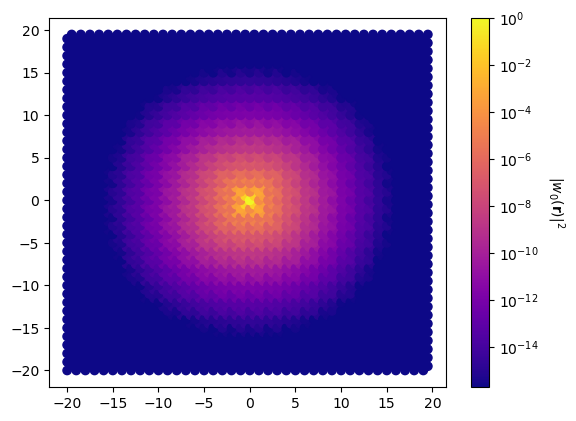

In [8]:
nkx, nky = 20, 20
Nk = nkx * nky
WFs = Wannier(model, [nkx, nky])
WFs.Wannierize(tf_list)
WFs.plot(0)
WFs.report()

[3]
(20, 20, 1, 8)
(20, 20, 4, 8)
(20, 20, 3, 8)
True
True
0 Omega_I: 10.856697450076279
1 Omega_I: 10.658561294976586
2 Omega_I: 10.652994533655
3 Omega_I: 10.507682925377031
4 Omega_I: 10.737408561319832
5 Omega_I: 10.758415877614203
6 Omega_I: 11.105872349933053
7 Omega_I: 11.229987407648784
8 Omega_I: 11.57970634856578
9 Omega_I: 11.809395022940972
min omegai (20, 20, 3, 8)
2nd proj (20, 20, 4, 8)
0 Omega_til = 63.76105503339711, Grad mag: 3807.2016953582815
1 Omega_til = 62.888280735002844, Grad mag: 1806.4831365282662
2 Omega_til = 62.34015898295946, Grad mag: 1252.34356346353
3 Omega_til = 61.81046979145891, Grad mag: 1137.8099509091517
4 Omega_til = 61.46484947621119, Grad mag: 1027.7195708839736
min omegatil (20, 20, 4, 8)
Wannier function report:
 --------------- 
Quadratic spread = [35.41906845 34.6833532  42.00745123 40.4719534 ]
Omega_i = 91.11697680052959
Omega_tilde = 61.46484947621119
Wannier centers = [[-0.00703508 -0.04052301]
 [ 0.02835996  1.03373351]
 [ 1.0397637  

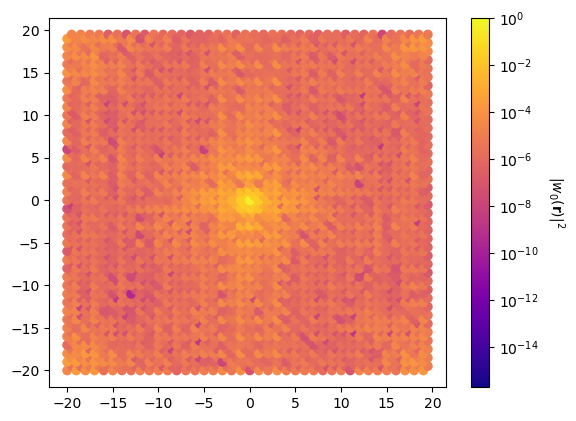

In [5]:
N_bands = n_tfs - 1
outer_window = "occupied"
inner_window = [3]
WFs.max_loc(
    N_wfs=N_bands, outer_window=outer_window, inner_window=inner_window,
    verbose=True, iter_num_omega_i=10, iter_num_omega_til=5, 
    eps=1e-4, tol_omega_i=1e-3, tol_omega_til=1e-3, grad_min=10
    )
WFs.plot(0)
WFs.report()

In [10]:
WFs.tilde_states._u_wfs.shape

(20, 20, 4, 8)

In [6]:
u_wfs = WFs.energy_eigstates.get_states()["Cell periodic"]
psi_wfs = WFs.energy_eigstates.get_states()["Bloch"]
tilde_states = WFs.get_tilde_states()
u_tilde = tilde_states["Cell periodic"]
psi_tilde = tilde_states["Bloch"]

H_k = WFs.get_Bloch_Ham()
H_tilde_k = u_wfs[..., :, :].conj() @ H_k @ np.transpose(u_wfs[..., : ,:], axes=(0,1,3,2))
H_rot_k = u_tilde[..., :, :].conj() @ H_k @ np.transpose(u_tilde[..., : ,:], axes=(0,1,3,2))

In [7]:
k_mesh = WFs.K_mesh.full_mesh
k_idx_arr = WFs.K_mesh.idx_arr

supercell = np.array([
    (i,j) 
    for i in range(-int((nkx-nkx%2)/2), int((nkx-nkx%2)/2)) for j in range(-int((nky-nky%2)/2), int((nky-nky%2)/2))
    ])

H_recip = H_rot_k
H_R = np.zeros((supercell.shape[0], H_recip.shape[-1], H_recip.shape[-1]), dtype=complex)

for idx, (x, y) in enumerate(supercell):
    for k_idx in k_idx_arr:
        R_vec = np.array([x, y])
        phase = np.exp(-1j * 2 * np.pi * np.vdot(k_mesh[k_idx], R_vec))
        H_R[idx, :, :] += H_recip[k_idx] * phase / Nk

In [8]:
nk = 101
k_path = [[0.0, 0.0], [0.0, 0.5], [0.5, 0.5], [0.0, 0.0]]
(k_vec, k_dist, k_node) = model.k_path(k_path, nk, report=False)

H_k_interp = np.zeros((k_vec.shape[0], H_R.shape[-1], H_R.shape[-1]), dtype=complex)

for k_idx, k in enumerate(k_vec):
    for idx, (x, y) in enumerate(supercell):
        R_vec = np.array([x, y])
        phase = np.exp(1j * 2 * np.pi * np.vdot(k, R_vec))
        H_k_interp[k_idx] += H_R[idx] * phase

Text(0, 0.5, 'Energy $E(\\mathbf{{k}})$ ')

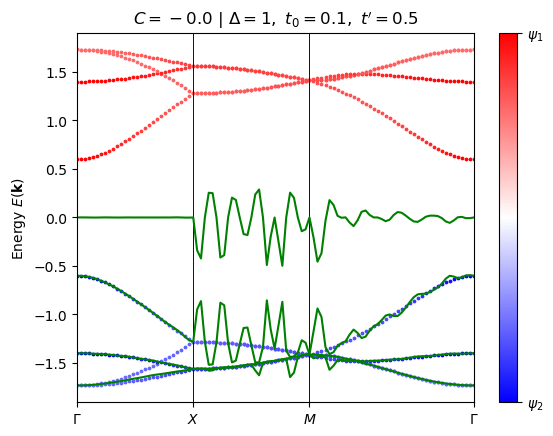

In [9]:
k_label = (r'$\Gamma $',r'$X$', r'$M$', r'$\Gamma $')
title = (rf"$C = {chern: .1f}$ | $\Delta = {delta},\ t_0 = {t0},\ t' = {tprime}$")
fig, ax = plot.plot_bands(
    model, k_path=k_path, k_label=k_label, sub_lat=True, red_lat_idx=high_E_sites, title=title)

evals, evecs = np.linalg.eigh(H_k_interp)
n_eigs = evals.shape[-1]

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
if k_label is not None:
    ax.set_xticklabels(k_label)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.5, color='k')

# continuous bands
for n in range(n_eigs):
    ax.plot(k_dist, evals[:, n], c='green')

ax.set_title(title)
ax.set_ylabel(r"Energy $E(\mathbf{{k}})$ ")